In [1]:
import os
import joblib
import tqdm
import time
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
import torch
from mmfe.MMFE import MMFE, denormalize

In [3]:
np.random.seed(2025)
torch.manual_seed(2025)
if torch.cuda.is_available():
    torch.cuda.manual_seed(2025)
    torch.cuda.manual_seed_all(2025)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
filepath = os.path.join('data', 'david.csv')

In [5]:
df_raw = pd.read_csv(filepath)

In [6]:
df_raw

,Kinase,Compound,compound_iso_smiles,affinity,label
0,EGFR,A-674563,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OC[C@H](CC4=C...,5.000000,0
1,EGFR(E746-A750del),A-674563,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OC[C@H](CC4=C...,5.000000,0
2,EGFR(G719C),A-674563,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OC[C@H](CC4=C...,5.000000,0
3,EGFR(G719S),A-674563,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OC[C@H](CC4=C...,5.000000,0
4,"EGFR(L747-E749del,A750P)",A-674563,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OC[C@H](CC4=C...,5.000000,0
...,...,...,...,...,...
859,EGFR(L858R),Vandetanib,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,8.060481,1
860,"EGFR(L858R,T790M)",Vandetanib,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,6.638272,1
861,EGFR(L861Q),Vandetanib,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,7.958607,1
862,EGFR(S752-I759del),Vandetanib,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,7.920819,1


In [7]:
df_raw['Kinase'].value_counts()

Kinase
EGFR                        72
EGFR(E746-A750del)          72
EGFR(G719C)                 72
EGFR(G719S)                 72
EGFR(L747-E749del,A750P)    72
EGFR(L747-S752del,P753S)    72
EGFR(L747-T751del,Sins)     72
EGFR(L858R)                 72
EGFR(L858R,T790M)           72
EGFR(L861Q)                 72
EGFR(S752-I759del)          72
EGFR(T790M)                 72
Name: count, dtype: int64

In [8]:
df_raw.groupby('Kinase').sum(numeric_only=True)

,affinity,label
Kinase,,
EGFR,411.854286,30
EGFR(E746-A750del),413.505460,31
EGFR(G719C),416.170369,36
EGFR(G719S),411.652954,32
"EGFR(L747-E749del,A750P)",418.632771,34
"EGFR(L747-S752del,P753S)",409.897679,31
"EGFR(L747-T751del,Sins)",413.901206,32
EGFR(L858R),414.353889,32
"EGFR(L858R,T790M)",409.776744,27


In [9]:
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

In [10]:
estimators = {}
records = []

for kinasename in tqdm.tqdm(df_raw['Kinase'].drop_duplicates()):
    df = df_raw.query(f"Kinase == '{kinasename}'")
    X = [mfpgen.GetFingerprint(Chem.MolFromSmiles(smi)).ToList() for smi in df['compound_iso_smiles']]
    X = np.array(X)
    y = df['label'].values

    ## fit
    ## - reference: https://scikit-learn.org/stable/modules/grid_search.html
    calibrated_forest = CalibratedClassifierCV(
       estimator=RandomForestClassifier(random_state=2025)
    )
    param_grid = {
       'estimator__n_estimators': [20, 40, 60, 80],
       'estimator__max_depth': [2, 4, 6, 8]
    }
    search = GridSearchCV(calibrated_forest, param_grid, cv=5)
    search.fit(X, y)

    ## store
    estimators[kinasename] = search.best_estimator_
    records.append({
        'Kinase': kinasename,
        'Accuracy': search.best_score_,
        'max_depth': search.best_params_['estimator__max_depth'],
        'n_estimators': search.best_params_['estimator__n_estimators']
    })
    #print(f"[{kinasename}] {search.best_score_:.3f}, {search.best_index_}, {search.best_params_}")

df_records = pd.DataFrame(records)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:46<00:00,  8.88s/it]


In [11]:
df_records

,Kinase,Accuracy,max_depth,n_estimators
0,EGFR,0.834286,8,20
1,EGFR(E746-A750del),0.751429,4,20
2,EGFR(G719C),0.653333,4,20
3,EGFR(G719S),0.723810,6,80
4,"EGFR(L747-E749del,A750P)",0.763810,8,80
5,"EGFR(L747-S752del,P753S)",0.820000,2,80
6,"EGFR(L747-T751del,Sins)",0.791429,2,20
7,EGFR(L858R),0.804762,4,40
8,"EGFR(L858R,T790M)",0.737143,8,80
9,EGFR(L861Q),0.779048,2,80


In [12]:
filepath_zinc = os.path.join('data', 'zinc250k.csv')
if not os.path.exists(filepath_zinc):
    os.system('wget https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv -q -O data/zinc250k.csv')

In [13]:
df_zinc = pd.read_csv(filepath_zinc).query('qed>0.7').reset_index(drop=True)

# canonicalization
for i in tqdm.trange(len(df_zinc)):
    m = Chem.MolFromSmiles(df_zinc.loc[i,'smiles'])
    df_zinc.loc[i,'smiles'] = Chem.MolToSmiles(m, kekuleSmiles=True, isomericSmiles=True, canonical=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 161617/161617 [00:30<00:00, 5287.75it/s]


In [14]:
df_zinc

,smiles,logP,qed,SAS
0,CC(C)(C)C1=CC=C2OC=C(CC(=O)NC3=CC=CC=C3F)C2=C1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(NC2=CN=CC(C3=NN=CN3C)=C2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#CC1=C(SCC(=O)NC2=CC=CC(Cl)=C2)N=C([O-])[C@H]...,3.60956,0.789027,4.035182
3,CC[NH+](CC)[C@](C)(CC)[C@H](O)C1=CSC=C1Br,2.63740,0.824369,5.091438
4,C[C@@H]1CN(C(=O)C2=CC(Br)=CN2C)CC[C@H]1[NH3+],0.88010,0.835024,3.947933
...,...,...,...,...
161612,COC1=CC(C[NH2+]C[C@@H](C)C[C@@H](C)O)=CC(Br)=C1O,1.63370,0.716664,4.196117
161613,CC1(C)CC[C@H](CNC(=O)CN2N=CC3=CC=CC=C3C2=O)C2=...,3.36790,0.745901,2.900726
161614,CN1C=CN=C1C(=O)C1=CC=C(NC(=O)C2CCN(C(=O)C(C)(C...,2.87430,0.799426,2.326627
161615,CC1=CC=C(NC(=O)C(=O)N(C)CC2=CC=CC=C2)C(C)=C1,2.90054,0.878086,1.840642


In [15]:
class MMFERegressor:
    def __init__(self):
        ## args
        self.input_dir_ckpt = os.path.join('results', '300nM', 'MMFE')
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.fold = 0
        ## load
        self.emb = MMFE(self.input_dir_ckpt, self.device, self.fold)
        self.emb.load_model()
        with open(os.path.join(self.input_dir_ckpt, f"Fold{self.fold+1}", "Ridge.pkl"), "rb") as f:
            self.reg = joblib.load(f)

    def predict(self, X):
        h = self.emb.predict(X)
        y = denormalize(self.reg.predict(h))
        return y

In [16]:
model = MMFERegressor()

/home/descartes/miniconda3/envs/mmfe/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
start_time = time.time()
sescore = model.predict(df_zinc['smiles'].values)
print(f"Execution Time: {time.time() - start_time:.0f} sec")

Execution Time: 2326 sec


In [18]:
df_res = df_zinc.copy()
df_res['sescore'] = sescore

In [19]:
X = []
for smi in tqdm.tqdm(df_zinc['smiles']):
    m = Chem.MolFromSmiles(smi)
    X.append(mfpgen.GetFingerprint(m).ToList())

X = np.array(X)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 161617/161617 [00:13<00:00, 11809.62it/s]


In [20]:
for kinasename, reg in tqdm.tqdm(estimators.items()):
    df_res[kinasename] = reg.predict_proba(X)[:,1]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.66s/it]


In [21]:
df_res

,smiles,logP,qed,SAS,sescore,EGFR,EGFR(E746-A750del),EGFR(G719C),EGFR(G719S),"EGFR(L747-E749del,A750P)","EGFR(L747-S752del,P753S)","EGFR(L747-T751del,Sins)",EGFR(L858R),"EGFR(L858R,T790M)",EGFR(L861Q),EGFR(S752-I759del),EGFR(T790M)
0,CC(C)(C)C1=CC=C2OC=C(CC(=O)NC3=CC=CC=C3F)C2=C1,5.05060,0.702012,2.084095,0.093746,0.314441,0.359104,0.443000,0.363951,0.304853,0.295948,0.299055,0.269901,0.256091,0.355051,0.194739,0.430006
1,C[C@@H]1CC(NC2=CN=CC(C3=NN=CN3C)=C2)C[C@@H](C)C1,3.11370,0.928975,3.432004,0.092751,0.178640,0.230725,0.430962,0.279116,0.272627,0.276668,0.321838,0.174584,0.250903,0.296671,0.166538,0.256608
2,N#CC1=C(SCC(=O)NC2=CC=CC(Cl)=C2)N=C([O-])[C@H]...,3.60956,0.789027,4.035182,0.100687,0.386321,0.318964,0.426157,0.325990,0.407604,0.436998,0.309957,0.420547,0.300804,0.471166,0.204113,0.339407
3,CC[NH+](CC)[C@](C)(CC)[C@H](O)C1=CSC=C1Br,2.63740,0.824369,5.091438,0.226556,0.224699,0.232019,0.460077,0.299243,0.173990,0.219275,0.286356,0.213272,0.255384,0.305033,0.183011,0.293385
4,C[C@@H]1CN(C(=O)C2=CC(Br)=CN2C)CC[C@H]1[NH3+],0.88010,0.835024,3.947933,0.079038,0.255010,0.265187,0.454606,0.331528,0.241842,0.224095,0.308137,0.216074,0.281172,0.324766,0.206307,0.346088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161612,COC1=CC(C[NH2+]C[C@@H](C)C[C@@H](C)O)=CC(Br)=C1O,1.63370,0.716664,4.196117,0.127799,0.376857,0.443080,0.555353,0.391450,0.273252,0.430355,0.458617,0.409594,0.332414,0.499320,0.427588,0.337836
161613,CC1(C)CC[C@H](CNC(=O)CN2N=CC3=CC=CC=C3C2=O)C2=...,3.36790,0.745901,2.900726,0.112039,0.284296,0.349478,0.458503,0.338412,0.424019,0.309055,0.338528,0.303612,0.301531,0.419400,0.262324,0.473416
161614,CN1C=CN=C1C(=O)C1=CC=C(NC(=O)C2CCN(C(=O)C(C)(C...,2.87430,0.799426,2.326627,0.121725,0.175615,0.271114,0.445858,0.294046,0.304118,0.266636,0.260336,0.199911,0.266479,0.339993,0.137669,0.257387
161615,CC1=CC=C(NC(=O)C(=O)N(C)CC2=CC=CC=C2)C(C)=C1,2.90054,0.878086,1.840642,0.080547,0.201385,0.237552,0.433113,0.279169,0.265630,0.220394,0.299096,0.196881,0.294897,0.296547,0.145166,0.361878


In [22]:
df_res['sescore'].describe()

count    161617.000000
mean          0.112862
std           0.042130
min           0.015658
25%           0.082380
50%           0.106724
75%           0.136463
max           0.370860
Name: sescore, dtype: float64

In [32]:
#target_kinase = 'EGFR(L858R,T790M)'
target_kinase = 'EGFR(T790M)'

output_dir = os.path.join('results', 'Drug_Screening')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

c = df_res[target_kinase] > 0.51
df_comp = df_res[c]
print(len(df_comp))

kinasenames = df_raw['Kinase'].drop_duplicates().values.tolist()
p = kinasenames.index(target_kinase)
if p > 0:
    kinasenames = [target_kinase,] + kinasenames[:p] + kinasenames[p+1:]

5578


In [33]:
df_comp.to_csv(os.path.join(output_dir, f"{target_kinase}.csv"), index=False)

In [34]:
df_test = df_comp.nlargest(n=10, columns=['sescore']).mean(numeric_only=True) \
    .to_frame() \
    .rename(columns={0:'AFFINITY'}) \
    .loc[kinasenames,:]

df_test['AFFINITY'] /= df_test.loc[target_kinase,'AFFINITY']

df_test['LABEL'] = 'w/MMFE'

In [35]:
df_ctrl = df_comp.nlargest(n=10, columns=[target_kinase]).mean(numeric_only=True) \
    .to_frame() \
    .rename(columns={0:'AFFINITY'}) \
    .loc[kinasenames,:]

df_ctrl['AFFINITY'] /= df_ctrl.loc[target_kinase,'AFFINITY']

df_ctrl['LABEL'] = 'wo/MMFE'

In [36]:
df_mean = pd.concat([
    df_ctrl,
    df_test,
]).reset_index().rename(columns={'index':'KINASE'})

In [37]:
df_mean

,KINASE,AFFINITY,LABEL
0,EGFR(T790M),1.000000,wo/MMFE
1,EGFR,0.843257,wo/MMFE
2,EGFR(E746-A750del),0.807165,wo/MMFE
3,EGFR(G719C),0.823053,wo/MMFE
4,EGFR(G719S),0.872145,wo/MMFE
5,"EGFR(L747-E749del,A750P)",0.904412,wo/MMFE
6,"EGFR(L747-S752del,P753S)",0.935545,wo/MMFE
7,"EGFR(L747-T751del,Sins)",0.850275,wo/MMFE
8,EGFR(L858R),0.943723,wo/MMFE
9,"EGFR(L858R,T790M)",0.622415,wo/MMFE


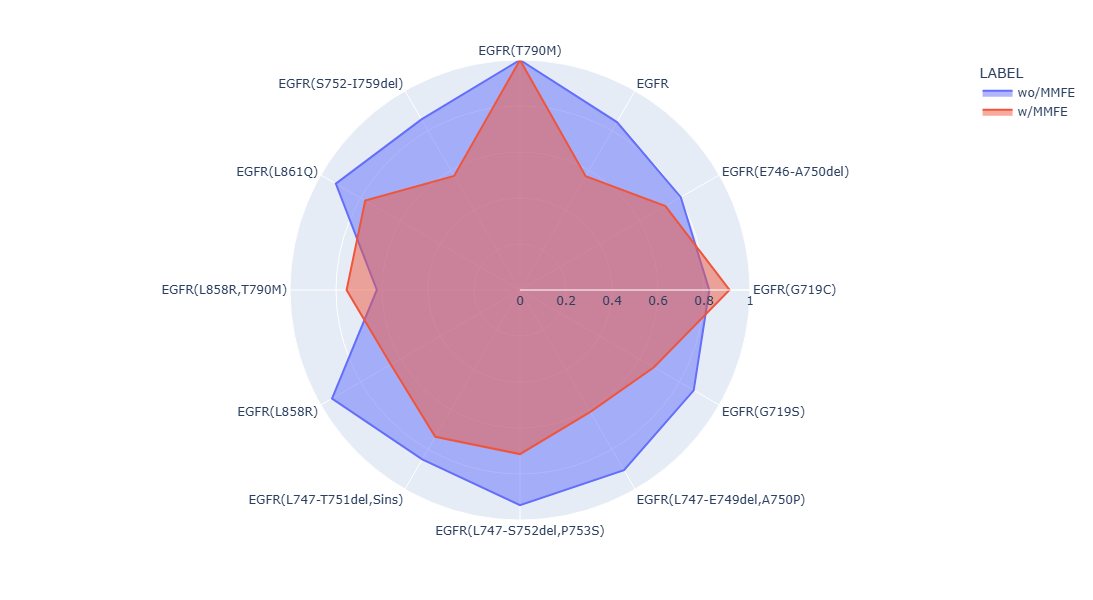

In [38]:
fig = px.line_polar(
    df_mean,
    r='AFFINITY',
    theta='KINASE',
    color='LABEL',
    line_close=True,
    width=600,
    height=600,
    #range_r=[0.5,1.1]
)
fig.update_traces(fill='toself')

#fig.write_image(os.path.join(output_dir, f"{target_kinase}.png"))
fig.show()